# SE/2015/026

# S. PRASANTH

## PREDICT AND GIVE QUANTITATIVE SCORE FOR COVID-19 USING CHEST CT IMAGES

In [1]:
import pydicom #For working with DICOM files
import os #For operating system dependend functionality
import pandas as pd #Data analysis and manipulation tool
import numpy as np #Package for linear algebra and multidimentional arrays
import tensorflow as tf #Deep learning tool
import cv2 #Image processing library

from sklearn.model_selection import train_test_split #For split the dataset into trained and test dataset
from sklearn.metrics import f1_score #F1 score
from sklearn.metrics import confusion_matrix #Confusion matrix

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras.backend as K #Transfer learning

#Keras Processing
from tqdm import tqdm
import inspect

#Build model
from tensorflow.keras.applications import VGG16, DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

## LOAD CSV DATA

In [2]:
#Load Trained Meta Dataset
trainedMetaData = pd.read_csv('../Dataset/CSV/CT Trained Metadata.csv', index_col=1)

trainedMetaData.head()

,Id,Dataset_type,Result,Image_Names
Label,,,,
ARDS,0,TRAIN,0,ARDS (1).jpg
ARDS,1,TRAIN,0,ARDS (2).jpg
COVID-19,2,TRAIN,1,Covid-19 (1).jpeg
COVID-19,3,TRAIN,1,Covid-19 (2).jpeg
COVID-19,4,TRAIN,1,Covid-19 (3).jpeg


In [3]:
#Trained dataset count
len(trainedMetaData)

5354

In [4]:
#Load Test Meta Dataset
testMetaData = pd.read_csv('../Dataset/CSV/CT Test Metadata.csv', index_col=1)

testMetaData.head()

,Id,Dataset_type,Image_Names
Label,,,
COVID-19,5377,TEST,Covid-19 (106).jpg
COVID-19,5378,TEST,Covid-19 (107).jpg
COVID-19,5379,TEST,Covid-19 (108).jpg
COVID-19,5380,TEST,Covid-19 (109).jpg
COVID-19,5381,TEST,Covid-19 (110).jpg


In [5]:
#Test dataset count
len(testMetaData)

599

## DATA PRE-PROCESSING

In [6]:
#Check for Null Values in Trained Meta Dataset
trainedMetaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5354 entries, ARDS to Streptococcus
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            5354 non-null   int64 
 1   Dataset_type  5354 non-null   object
 2   Result        5354 non-null   int64 
 3   Image_Names   5354 non-null   object
dtypes: int64(2), object(2)
memory usage: 209.1+ KB


In [7]:
#Check for Data duplications in Trained Meta Dataset
trainedMetaData.duplicated().sum()

0

In [8]:
#Check for Null Values in Test Meta Dataset
testMetaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599 entries, COVID-19 to SARS
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            599 non-null    int64 
 1   Dataset_type  599 non-null    object
 2   Image_Names   599 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.7+ KB


In [9]:
#Check for Data duplications in Test Meta Dataset
trainedMetaData.duplicated().sum()

0

In [10]:
#Summary of Whole Meta Dataset
metaSummaryData = pd.read_csv('../Dataset/CSV/CT Metadata Summary.csv', index_col=1)

metaSummaryData.head(8)

,Label
Image_Count,
117,COVID-19
1576,Normal
2,ARDS
2773,Pnemonia Bacteria
1469,Pnemonia Virus
11,SARS
5,Streptococcus
5953,Total


## DISPLAY CT IMAGE

In [11]:
#Function to display Image
def ShowCTImage(titleNoise, titleNoiseRemoval, image):
    image_noise = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_denoise = cv2.GaussianBlur(image, (5, 5), 0)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (12, 10))
    
    ax1.imshow(image_noise, cmap = 'gray')
    ax2.imshow(img_denoise, cmap = 'gray')
    
    ax1.set_title(titleNoise)
    ax1.grid(False)
    
    ax2.set_title(titleNoiseRemoval)
    ax2.grid(False)

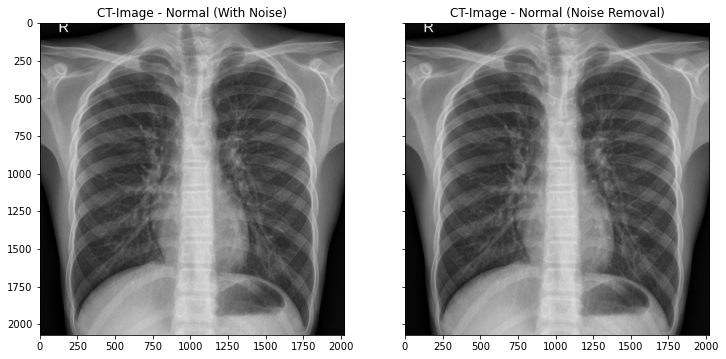

In [12]:
#Call diplay Healthy Patient's Chest CT Image
fileName = "../Dataset/CT/TRAIN/Normal (33).jpeg"
image = cv2.imread(fileName)
ShowCTImage("CT-Image - Normal (With Noise)", "CT-Image - Normal (Noise Removal)", image)

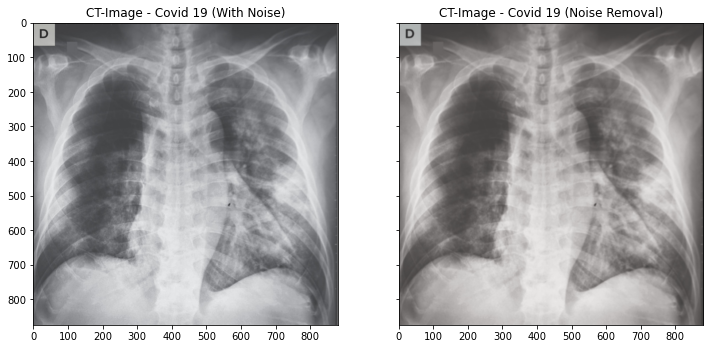

In [13]:
#Call diplay Covid-19 Patient's Chest CT Image
fileName = "../Dataset/CT/TRAIN/Covid-19 (5).jpeg"
image = cv2.imread(fileName)
ShowCTImage("CT-Image - Covid 19 (With Noise)", "CT-Image - Covid 19 (Noise Removal)", image)

## LOAD IMAGES

In [14]:
trainedImageArray = []
imageSize = 224
testImageArray = []

#Load and resize trained images
for i in range(len(trainedMetaData)):
    imgPath = "../Dataset/CT/TRAIN/" + trainedMetaData['Image_Names'][i] #Image path
    
    img = cv2.imread(imgPath) #Read image
    imgArray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image color to RGB
    newImgArray = cv2.resize(imgArray, (imageSize, imageSize)) #Resize image
    
    trainedImageArray.append([newImgArray, trainedMetaData['Result'][i]]) #Load trained images into an array

In [15]:
#Total trained imageset
print(len(trainedImageArray))

5354


In [16]:
#Load and resize test images
for i in range(len(testMetaData)):
    imgPath = "../Dataset/CT/TEST/" + testMetaData['Image_Names'][i] #Image path
    
    img = cv2.imread(imgPath) #Read image
    imgArray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image color to RGB
    newImgArray = cv2.resize(imgArray, (imageSize, imageSize)) #Resize image
    
    testImageArray.append(newImgArray) #Load trained images into an array

In [17]:
#Total test imageset
print(len(testImageArray))

599


In [18]:
#Suffle trained images
np.random.shuffle(trainedImageArray)

x = []
y = []

for image in trainedImageArray:
    x.append(image[0])
    y.append(image[1])

#Convert x and y to numpy array
x = np.array(x)
y = np.array(y)

In [19]:
#Compare Covid-19 and Non Covid-19 trained data count
print(pd.Series(y).value_counts())

0    5249
1     105
dtype: int64


In [20]:
#Function to display random images
def PrintRandomSamples():
    index_0 = []
    index_1 = []

    for i, v in enumerate(y):
        if v == 1:
            index_1.append(i)
        else:
            index_0.append(i)

    plot_index_0 = np.random.choice(index_0)
    plot_index_1 = np.random.choice(index_1)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,10))

    ax1.imshow(x[plot_index_0],cmap = 'gray')
    ax2.imshow(x[plot_index_1],cmap = 'gray')

    ax1.set_title(y[plot_index_0])
    ax2.set_title(y[plot_index_1])

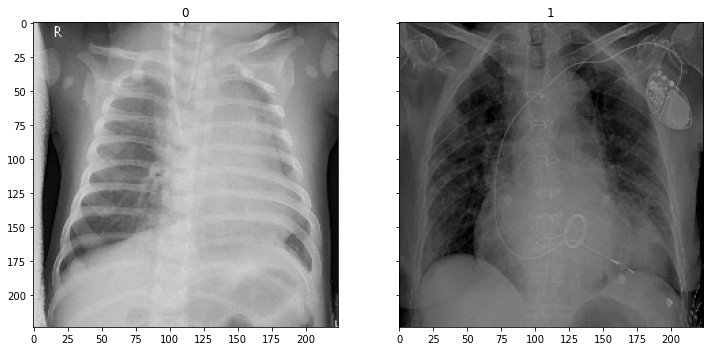

In [21]:
#Validate print random images
PrintRandomSamples()

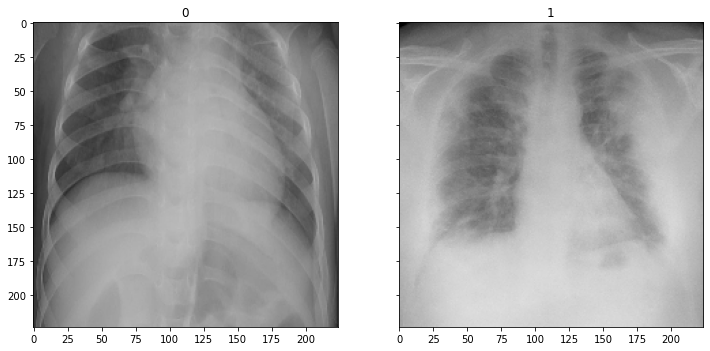

In [22]:
#Validate print random images
PrintRandomSamples()

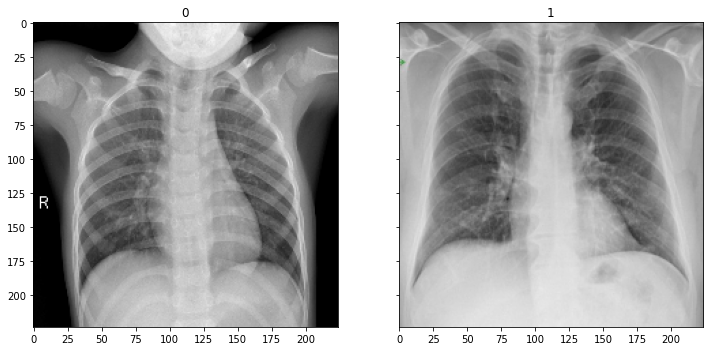

In [23]:
#Validate print random images
PrintRandomSamples()

## TRAIN-TEST SPLIT

In [24]:
#Train-Test split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [25]:
testImageArray = np.array(testImageArray)

testImageArray = testImageArray / 255

print(X_train.shape, X_val.shape, testImageArray.shape)

(4283, 224, 224, 3) (1071, 224, 224, 3) (599, 224, 224, 3)


In [26]:
#Return y_val counts of unique values
pd.Series(y_val).value_counts(normalize = True)

0    0.980392
1    0.019608
dtype: float64

In [27]:
#Return y_train counts of unique values
pd.Series(y_train).value_counts(normalize = True)

0    0.980388
1    0.019612
dtype: float64

In [28]:
print(X_train.shape, X_val.shape)

(4283, 224, 224, 3) (1071, 224, 224, 3)


## KERAS PROCESSING

In [32]:
batchSize = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)

train_generator = train_datagen.flow(X_train, y_train, batch_size = batchSize)

val_generator = val_datagen.flow(X_val, y_val, batch_size = batchSize)

In [33]:
#List of all avialable models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

{'DenseNet121': <function tensorflow.python.keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'DenseNet169': <function tensorflow.python.keras.applications.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'DenseNet201': <function tensorflow.python.keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)>,
 'EfficientNetB0': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB0(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 'EfficientNetB1': <function tensorflow.python.keras.applications.efficientnet.EfficientNetB1(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=

In [34]:
# Loop over each model available in keras
num_train = len(list(X_train))
num_validation = len(list(X_val))
num_classes = 1
num_iterations = len(X_train) // batchSize

In [35]:
#Keras Selector Processing
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

for model_name, model in tqdm(model_dictionary.items()):
    if model_name != 'NASNetLarge':
        input_shape=(224,224,3)
        train_processed = X_train
        validation_processed = X_val
        
        pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
        pre_trained_model.trainable = False
        
        clf_model = tf.keras.models.Sequential()
        clf_model.add(pre_trained_model)
        clf_model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))
        clf_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
        
        history = clf_model.fit(train_generator,
                       epochs=3,
                       validation_data=val_generator,
                       steps_per_epoch=num_iterations)
        
        model_benchmarks['model_name'].append(model_name)
        model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
        model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

Epoch 1/3
133/133 [==============================] - 534s 4s/step - loss: 0.0690 - accuracy: 0.9781 - val_loss: 0.0331 - val_accuracy: 0.9879
Epoch 2/3
133/133 [==============================] - 538s 4s/step - loss: 0.0263 - accuracy: 0.9908 - val_loss: 0.0242 - val_accuracy: 0.9935
Epoch 3/3
133/133 [==============================] - 539s 4s/step - loss: 0.0193 - accuracy: 0.9922 - val_loss: 0.0210 - val_accuracy: 0.9925


  4%|███                                                                           | 1/26 [27:47<11:34:45, 1667.42s/it]

Epoch 1/3
133/133 [==============================] - 656s 5s/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 0.0251 - val_accuracy: 0.9897
Epoch 2/3
133/133 [==============================] - 654s 5s/step - loss: 0.0209 - accuracy: 0.9915 - val_loss: 0.0194 - val_accuracy: 0.9925
Epoch 3/3
133/133 [==============================] - 656s 5s/step - loss: 0.0158 - accuracy: 0.9939 - val_loss: 0.0187 - val_accuracy: 0.9925


  8%|█████▊                                                                      | 2/26 [1:01:05<11:46:41, 1766.72s/it]

Epoch 1/3
133/133 [==============================] - 864s 6s/step - loss: 0.0680 - accuracy: 0.9817 - val_loss: 0.0311 - val_accuracy: 0.9869
Epoch 2/3
133/133 [==============================] - 859s 6s/step - loss: 0.0228 - accuracy: 0.9918 - val_loss: 0.0254 - val_accuracy: 0.9879
Epoch 3/3
133/133 [==============================] - 859s 6s/step - loss: 0.0165 - accuracy: 0.9927 - val_loss: 0.0239 - val_accuracy: 0.9925


 12%|████████▊                                                                   | 3/26 [1:44:50<12:55:51, 2023.98s/it]

Epoch 1/3
133/133 [==============================] - 282s 2s/step - loss: 0.1672 - accuracy: 0.9725 - val_loss: 0.0965 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 280s 2s/step - loss: 0.1035 - accuracy: 0.9802 - val_loss: 0.0970 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 280s 2s/step - loss: 0.1001 - accuracy: 0.9805 - val_loss: 0.0965 - val_accuracy: 0.9804


 15%|███████████▋                                                                | 4/26 [1:59:12<10:14:22, 1675.55s/it]

Epoch 1/3
133/133 [==============================] - 391s 3s/step - loss: 0.1663 - accuracy: 0.9732 - val_loss: 0.0965 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 389s 3s/step - loss: 0.1043 - accuracy: 0.9802 - val_loss: 0.0966 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 390s 3s/step - loss: 0.0988 - accuracy: 0.9807 - val_loss: 0.0966 - val_accuracy: 0.9804


 19%|██████████████▊                                                              | 5/26 [2:19:07<8:55:56, 1531.26s/it]

Epoch 1/3
133/133 [==============================] - 418s 3s/step - loss: 0.1216 - accuracy: 0.9729 - val_loss: 0.0969 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 414s 3s/step - loss: 0.0965 - accuracy: 0.9807 - val_loss: 0.0978 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 415s 3s/step - loss: 0.0989 - accuracy: 0.9802 - val_loss: 0.0966 - val_accuracy: 0.9804


 23%|█████████████████▊                                                           | 6/26 [2:40:19<8:04:28, 1453.43s/it]

Epoch 1/3
133/133 [==============================] - 549s 4s/step - loss: 0.1111 - accuracy: 0.9800 - val_loss: 0.0966 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 546s 4s/step - loss: 0.0985 - accuracy: 0.9805 - val_loss: 0.0976 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 548s 4s/step - loss: 0.0993 - accuracy: 0.9802 - val_loss: 0.0985 - val_accuracy: 0.9804


 27%|████████████████████▋                                                        | 7/26 [3:08:13<8:01:15, 1519.78s/it]

Epoch 1/3
133/133 [==============================] - 738s 6s/step - loss: 0.1106 - accuracy: 0.9741 - val_loss: 0.0966 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 736s 6s/step - loss: 0.0989 - accuracy: 0.9802 - val_loss: 0.0967 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 736s 6s/step - loss: 0.0978 - accuracy: 0.9802 - val_loss: 0.1006 - val_accuracy: 0.9804


 31%|███████████████████████▋                                                     | 8/26 [3:45:42<8:41:35, 1738.64s/it]

Epoch 1/3
133/133 [==============================] - 1030s 8s/step - loss: 0.1066 - accuracy: 0.9807 - val_loss: 0.1003 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 1027s 8s/step - loss: 0.0981 - accuracy: 0.9805 - val_loss: 0.0966 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 1032s 8s/step - loss: 0.0991 - accuracy: 0.9802 - val_loss: 0.0974 - val_accuracy: 0.9804


 35%|██████████████████████████▎                                                 | 9/26 [4:38:00<10:11:29, 2158.21s/it]

Epoch 1/3
133/133 [==============================] - 1360s 10s/step - loss: 0.1119 - accuracy: 0.9737 - val_loss: 0.1008 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 1349s 10s/step - loss: 0.0994 - accuracy: 0.9805 - val_loss: 0.0969 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 1352s 10s/step - loss: 0.0968 - accuracy: 0.9807 - val_loss: 0.1044 - val_accuracy: 0.9804


 38%|████████████████████████████▊                                              | 10/26 [5:46:48<12:13:09, 2749.33s/it]

Epoch 1/3
133/133 [==============================] - 1913s 14s/step - loss: 0.1093 - accuracy: 0.9786 - val_loss: 0.1010 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 1902s 14s/step - loss: 0.0999 - accuracy: 0.9802 - val_loss: 0.0992 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 1895s 14s/step - loss: 0.0998 - accuracy: 0.9802 - val_loss: 0.0998 - val_accuracy: 0.9804


 42%|███████████████████████████████▋                                           | 11/26 [7:23:49<15:17:39, 3670.65s/it]

Epoch 1/3
133/133 [==============================] - 782s 6s/step - loss: 0.0498 - accuracy: 0.9828 - val_loss: 0.0311 - val_accuracy: 0.9888
Epoch 2/3
133/133 [==============================] - 781s 6s/step - loss: 0.0239 - accuracy: 0.9896 - val_loss: 0.0215 - val_accuracy: 0.9925
Epoch 3/3
133/133 [==============================] - 765s 6s/step - loss: 0.0187 - accuracy: 0.9925 - val_loss: 0.0210 - val_accuracy: 0.9935


 46%|██████████████████████████████████▌                                        | 12/26 [8:03:32<12:46:24, 3284.58s/it]

Epoch 1/3
133/133 [==============================] - 332s 2s/step - loss: 0.0671 - accuracy: 0.9755 - val_loss: 0.0288 - val_accuracy: 0.9888
Epoch 2/3
133/133 [==============================] - 331s 2s/step - loss: 0.0259 - accuracy: 0.9899 - val_loss: 0.0242 - val_accuracy: 0.9888
Epoch 3/3
133/133 [==============================] - 331s 2s/step - loss: 0.0181 - accuracy: 0.9925 - val_loss: 0.0227 - val_accuracy: 0.9888


 50%|██████████████████████████████████████                                      | 13/26 [8:20:28<9:24:11, 2603.97s/it]

Epoch 1/3
133/133 [==============================] - 179s 1s/step - loss: 0.0428 - accuracy: 0.9852 - val_loss: 0.0234 - val_accuracy: 0.9916
Epoch 2/3
133/133 [==============================] - 140s 1s/step - loss: 0.0164 - accuracy: 0.9939 - val_loss: 0.0209 - val_accuracy: 0.9925
Epoch 3/3
133/133 [==============================] - 140s 1s/step - loss: 0.0115 - accuracy: 0.9951 - val_loss: 0.0215 - val_accuracy: 0.9916


 54%|████████████████████████████████████████▉                                   | 14/26 [8:28:20<6:32:50, 1964.20s/it]

Epoch 1/3
133/133 [==============================] - 150s 1s/step - loss: 0.0545 - accuracy: 0.9838 - val_loss: 0.0321 - val_accuracy: 0.9925
Epoch 2/3
133/133 [==============================] - 147s 1s/step - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0242 - val_accuracy: 0.9925
Epoch 3/3
133/133 [==============================] - 149s 1s/step - loss: 0.0165 - accuracy: 0.9936 - val_loss: 0.0217 - val_accuracy: 0.9925


 58%|███████████████████████████████████████████▊                                | 15/26 [8:35:59<4:37:19, 1512.69s/it]

Epoch 1/3
133/133 [==============================] - 318s 2s/step - loss: 0.0664 - accuracy: 0.9821 - val_loss: 0.0385 - val_accuracy: 0.9851
Epoch 2/3
133/133 [==============================] - 312s 2s/step - loss: 0.0261 - accuracy: 0.9904 - val_loss: 0.0289 - val_accuracy: 0.9907
Epoch 3/3
133/133 [==============================] - 312s 2s/step - loss: 0.0205 - accuracy: 0.9934 - val_loss: 0.0264 - val_accuracy: 0.9907


 65%|█████████████████████████████████████████████████▋                          | 17/26 [8:52:28<3:01:05, 1207.33s/it]

Epoch 1/3
133/133 [==============================] - 882s 7s/step - loss: 0.1019 - accuracy: 0.9803 - val_loss: 0.0928 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 875s 7s/step - loss: 0.0930 - accuracy: 0.9802 - val_loss: 0.0900 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 878s 7s/step - loss: 0.0902 - accuracy: 0.9802 - val_loss: 0.0874 - val_accuracy: 0.9804


 69%|████████████████████████████████████████████████████▌                       | 18/26 [9:37:01<3:39:34, 1646.82s/it]

Epoch 1/3
133/133 [==============================] - 887s 7s/step - loss: 0.0516 - accuracy: 0.9835 - val_loss: 0.0279 - val_accuracy: 0.9888
Epoch 2/3
133/133 [==============================] - 883s 7s/step - loss: 0.0158 - accuracy: 0.9941 - val_loss: 0.0222 - val_accuracy: 0.9897
Epoch 3/3
133/133 [==============================] - 881s 7s/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0215 - val_accuracy: 0.9897


 73%|██████████████████████████████████████████████████████▊                    | 19/26 [10:22:02<3:49:01, 1963.02s/it]

Epoch 1/3
133/133 [==============================] - 1327s 10s/step - loss: 0.0982 - accuracy: 0.9805 - val_loss: 0.0953 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 1331s 10s/step - loss: 0.0969 - accuracy: 0.9802 - val_loss: 0.0954 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 1326s 10s/step - loss: 0.0949 - accuracy: 0.9805 - val_loss: 0.0958 - val_accuracy: 0.9804


 77%|█████████████████████████████████████████████████████████▋                 | 20/26 [11:29:43<4:19:14, 2592.38s/it]

Epoch 1/3
133/133 [==============================] - 1349s 10s/step - loss: 0.0951 - accuracy: 0.9682 - val_loss: 0.0298 - val_accuracy: 0.9879
Epoch 2/3
133/133 [==============================] - 1327s 10s/step - loss: 0.0199 - accuracy: 0.9925 - val_loss: 0.0293 - val_accuracy: 0.9916
Epoch 3/3
133/133 [==============================] - 1328s 10s/step - loss: 0.0142 - accuracy: 0.9946 - val_loss: 0.0300 - val_accuracy: 0.9916


 81%|████████████████████████████████████████████████████████████▌              | 21/26 [12:38:16<4:14:03, 3048.60s/it]

Epoch 1/3
133/133 [==============================] - 517s 4s/step - loss: 0.1084 - accuracy: 0.9807 - val_loss: 0.0972 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 515s 4s/step - loss: 0.0958 - accuracy: 0.9802 - val_loss: 0.0959 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 517s 4s/step - loss: 0.0931 - accuracy: 0.9805 - val_loss: 0.0942 - val_accuracy: 0.9804


 85%|███████████████████████████████████████████████████████████████▍           | 22/26 [13:04:34<2:53:50, 2607.51s/it]

Epoch 1/3
133/133 [==============================] - 478s 4s/step - loss: 0.0774 - accuracy: 0.9729 - val_loss: 0.0277 - val_accuracy: 0.9888
Epoch 2/3
133/133 [==============================] - 473s 4s/step - loss: 0.0173 - accuracy: 0.9932 - val_loss: 0.0237 - val_accuracy: 0.9907
Epoch 3/3
133/133 [==============================] - 473s 4s/step - loss: 0.0132 - accuracy: 0.9946 - val_loss: 0.0228 - val_accuracy: 0.9916


 88%|██████████████████████████████████████████████████████████████████▎        | 23/26 [13:28:41<1:52:57, 2259.23s/it]

Epoch 1/3
133/133 [==============================] - 1469s 11s/step - loss: 0.1045 - accuracy: 0.9807 - val_loss: 0.0895 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 1465s 11s/step - loss: 0.0853 - accuracy: 0.9802 - val_loss: 0.0827 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 1465s 11s/step - loss: 0.0784 - accuracy: 0.9802 - val_loss: 0.0769 - val_accuracy: 0.9804


 92%|█████████████████████████████████████████████████████████████████████▏     | 24/26 [14:42:30<1:37:00, 2910.32s/it]

Epoch 1/3
133/133 [==============================] - 1804s 14s/step - loss: 0.0996 - accuracy: 0.9802 - val_loss: 0.0876 - val_accuracy: 0.9804
Epoch 2/3
133/133 [==============================] - 1794s 13s/step - loss: 0.0831 - accuracy: 0.9805 - val_loss: 0.0809 - val_accuracy: 0.9804
Epoch 3/3
133/133 [==============================] - 1795s 13s/step - loss: 0.0769 - accuracy: 0.9805 - val_loss: 0.0756 - val_accuracy: 0.9804


 96%|████████████████████████████████████████████████████████████████████████   | 25/26 [16:13:06<1:01:08, 3668.05s/it]

Epoch 1/3
133/133 [==============================] - 619s 5s/step - loss: 0.0511 - accuracy: 0.9807 - val_loss: 0.0259 - val_accuracy: 0.9916
Epoch 2/3
133/133 [==============================] - 618s 5s/step - loss: 0.0200 - accuracy: 0.9922 - val_loss: 0.0220 - val_accuracy: 0.9916
Epoch 3/3
133/133 [==============================] - 617s 5s/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0248 - val_accuracy: 0.9916


100%|█████████████████████████████████████████████████████████████████████████████| 26/26 [16:47:35<00:00, 2325.22s/it]


In [36]:
# Convert result to dataframe for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('validation_accuracy', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('../Dataset/CSV/Keras_Model_Benchmark.csv', index=False) # write results to csv
benchmark_df

,model_name,num_model_params,validation_accuracy
8,EfficientNetB5,28513527,0.980392
22,VGG16,14714688,0.980392
18,ResNet152,58370944,0.980392
3,EfficientNetB0,4049571,0.980392
4,EfficientNetB1,6575239,0.980392
5,EfficientNetB2,7768569,0.980392
6,EfficientNetB3,10783535,0.980392
7,EfficientNetB4,17673823,0.980392
16,ResNet101,42658176,0.980392
9,EfficientNetB6,40960143,0.980392


In [37]:
#Function to calculate F1 Score
def get_f1(yTrue, yPred):
    truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
    possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
    predictedPositives = K.sum(K.round(K.clip(yPred, 0, 1)))
    
    precision = truePositives / (predictedPositives + K.epsilon())
    recall = truePositives / (possiblePositives + K.epsilon())
    
    f1Val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1Val

In [2]:
##If You Choose VGG16 as training model

##Create Convolutional
# conv_base = VGG16(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

##Dife Trained Layers
# train_layers = [layer.name for layer in conv_base.layers[::-1][:5]]
# train_layers

##Function to build model using Keras sequencial model with VGG16
# def buildModel():
#     model = tf.keras.models.Sequential()

#     model.add(conv_base)

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(512, activation = 'relu'))
#     model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

#     for layer in conv_base.layers:
#         if layer.name in train_layers:
#             layer.trainable = True
#         else:
#             layer.trainable = False

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = [get_f1])
    
#     return model

## BUILD MODEL

In [39]:
def buildModel():
    model = Sequential()

    conv_base = DenseNet201(input_shape = (224, 224, 3), include_top = False, pooling = 'max', weights = 'imagenet')
    model.add(conv_base)

    model.add(BatchNormalization())
    model.add(Dense(2048, activation = 'relu', kernel_regularizer = l1_l2(0.01)))
    model.add(BatchNormalization())
    
    model.add(Dense(1, activation = 'sigmoid'))

    for layer in model.layers:
        layer.trainable = True

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy', get_f1])
    
    return model

In [40]:
model = buildModel()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_301 (Bat (None, 1920)              7680      
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_302 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 2049      
Total params: 22,274,113
Trainable params: 22,037,121
Non-trainable params: 236,992
_________________________________________________________________


## TRAIN MODEL

In [42]:
stepsPerEpoch = len(X_train) // batchSize
epochs = 20
validationSteps = len(X_val) // batchSize

callBacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 1, min_lr = 1e-5, verbose = 0),
       tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-6, patience = 10, verbose = 1, mode = 'auto')]

In [ ]:
#Train the model
model.fit(
    train_generator, 
    steps_per_epoch = stepsPerEpoch, 
    epochs = epochs, 
    validation_data = val_generator, 
    validation_steps = validationSteps, 
    callbacks = callBacks,
    class_weight = {0:1, 1:2}
)

Epoch 1/20
112/133 [========================>.....] - ETA: 1:01:54 - loss: 584.3352 - accuracy: 0.6465 - get_f1: 0.1130

### EVALUATE VALIDATION DATA

In [ ]:
preds = model.predict(X_val / 255.0)
predictions = []

In [ ]:
for i in preds:
    if i > 0.5:
        predictions.append(1)
    else :
        predictions.append(0)
        
fScore = f1_score(y_val, predictions)

print(fScore)

In [ ]:
#Confusion Matrix
conMatrix = confusion_matrix(y_val, predictions)
sns.heatmap(conMatrix, annot = True, fmt = '.2f', xticklabels = ['Actual', 'Predicted'], yticklabels = ['Actual', 'Predicted'])

## PREDICT TEST DATA

In [ ]:
preds = model.predict(testImageArray)
predictions = []
severity = []

In [ ]:
for i in preds:
    if i[0] > 0.5:
        predictions.append(1)
        
        percentage = str(i[0] * 100) + "%"
        severity.append(percentage)
    else:
        predictions.append(0)
        severity.append("0%")

In [ ]:
sns.countplot(predictions)

In [ ]:
testImgPathArray = []

for i in range(len(testMetaData)):
    testImgPathArray.append(testMetaData['Image_Names'][i])

In [ ]:
result = pd.DataFrame({
    'Images': testImgPathArray,
    'prediction': predictions,
    'Severity': severity
})

result.to_csv('../Dataset/CSV/Predicted_Results.csv', index=False)

In [ ]:
result['prediction'].value_counts()

In [ ]:
#GRAD-CAM
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import argparse
import imutils

## GRAD_CAM CLASS

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName = None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
            
        raise ValueError("Could not find 4D layer, Cannot apply GradCAM")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
                        inputs = [self.model.input],
                        outputs = [self.model.get_layer(self.layerName).output, self.model.output]
                    )
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        grads = tape.gradient(loss, convOutputs)
        
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        weights = tf.reduce_mean(guidedGrads, axis = (0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis = -1)
        
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 225).astype("uint8")
        
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha = 0.5, colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        return (heatmap, output)

In [ ]:
covidImages = trainedMetaData[trainedMetaData['Result'] == 1]['Image_Names'].values.tolist()

In [ ]:
for i in range(5):
    index = np.random.randint(0, len(covidImages)) 
    image = "../Dataset/CT/TRAIN/" + covidImages[index]
    orig = cv2.imread(image)
    resied = cv2.resize(orig, (224, 224))
    
    image = load_img(image, target_size = (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = imagenet_utils.preprocess_input(image)
    
    preds = model.predict(image)
    i = np.argmax(preds[0])
    
    label = "Covid Affected"
    
    cam = GradCAM(model, i)
    heatmap = cam.compute_heatmap(image)
    
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha = 0.5)
    
    cv2.rectangle(output, (0, 0), (orig.shape[1], orig.shape[0]), (0, 0, 0), 2)
    cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    output = np.hstack([orig, heatmap, output])
    output = imutils.resize(output, height = 700)
    
    cv2_imshow(output)

### THE END!